在 Python 中使用 MATLAB Signal Labeler


匯入所需函示庫

In [11]:
import matlab
import matlab.engine as eng 
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import os

建立與現有 MATLAB Session 連結

In [14]:
# 找到現有執行中的 MATLAB Session ID
# In MATLAB: matlab.engine.shareEngine
matlab_ID = eng.find_matlab()
print(matlab_ID)

# 選取欲建立連結的 MATLAB Session
sess = eng.connect_matlab(matlab_ID[0])
print(sess)

('MATLAB_13200',)


EngineError: Unable to connect to MATLAB session 'MATLAB_13200'.

調用MATLAB中函式

In [15]:
# Add Search Path
demo_path =  'C:\\Users\\Tim\\Desktop\\terasoft\\活動與研討會資料\\MTK Day\\Demo\\Using MATLAB App in Python_Signal'
os.chdir(demo_path)

# 圖檔資料夾路徑
signal_path = 'C:/Users/Tim/Desktop/terasoft/活動與研討會資料/MTK Day/Demo/Dataset/QTDataset/'
ds = sess.signalDatastore(signal_path,
    'SignalVariableNames','ecgSignal',
    'SampleRateVariableName','Fs')

# 建立subset
indices = matlab.double(range(1,6)) # 取5筆訊號
subsds = sess.subset(ds,indices)
labeled_ds = sess.labeledSignalSet(subsds)
sess.workspace['labeled_ds'] = labeled_ds

在 Python 中調用 MATLAB APP

In [16]:
sess.signalLabeler(nargout=0) # Open with image dataset imported 

In [18]:
label_table = sess.workspace['ls']
out = sess.getLabeledSignal(label_table)    # Convert MATLAB format [xmin, ymin, w, h] -> Pytorch [xmin, ymin, xmax, ymax]

sess.saveToJSON(out, 'LabeledSignal.json',nargout=0)     # Save MATLAB table into json format file
LabeledSignal_df = pd.read_json('LabeledSignal.json')

print(LabeledSignal_df)


                                              Signal  \
0  [-79, -77, -79, -81, -80, -83, -84, -86, -82, ...   
1  [3, 3, 3, 3, 3, 4, 11, 14, 15, 20, 29, 32, 33,...   
2  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, ...   
3  [-18, -18, -18, -18, -17, -17, -18, -18, -17, ...   
4  [11, 11, 11, 11, 11, 12, 14, 13, 12, 12, 13, 1...   

                                           ECG_Label  
0  [{'ROILimits': [0.352, 0.456], 'Value': 'P'}, ...  
1                                                 []  
2                                                 []  
3                                                 []  
4                                                 []  


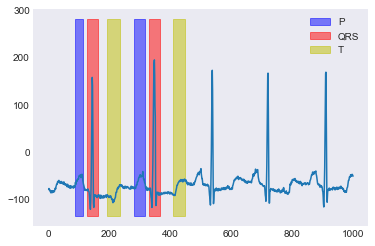

In [19]:
# 設定繪圖風格
style.use('seaborn-dark')

fs = 250    # Sample rate
signal_1 = LabeledSignal_df.Signal[0]
mask_P = np.zeros_like(signal_1)    # Mask for P-state
mask_QRS = np.zeros_like(signal_1)    # Mask for QRS-state
mask_T = np.zeros_like(signal_1)    # Mask for T-state
for item in LabeledSignal_df['ECG_Label'][0]:
    label_info = list(item.values())
    ROI = np.int64(np.array(label_info[0])*fs)    # Time -> Data points
    Label = label_info[1]   # State Label
    if Label == 'P':
        mask_P[ROI[0]:ROI[1]] = 1
    elif Label == 'QRS':
        mask_QRS[ROI[0]:ROI[1]] = 1
    else:
        mask_T[ROI[0]:ROI[1]] = 1

# 繪圖
x = np.arange(len(signal_1))
y_min = min(signal_1)
y_max = max(signal_1)
plt.plot(signal_1[:1000])   # Raw Signal
plt.fill_between(x, y_min, y_max, where=mask_P, color='b', alpha=0.5, label='P')
plt.fill_between(x, y_min, y_max, where=mask_QRS, color='r', alpha=0.5, label='QRS')
plt.fill_between(x, y_min, y_max, where=mask_T, color='y', alpha=0.5, label='T')
plt.legend()

測試 Bounding Box 

In [ ]:
# Terminate MATLAB session
sess.exit()